In [1]:
from brian2 import *

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'V_post += delta_V * rand() (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'V_post += delta_V * rand() (in-place)'
 [brian2.codegen.generators.base]


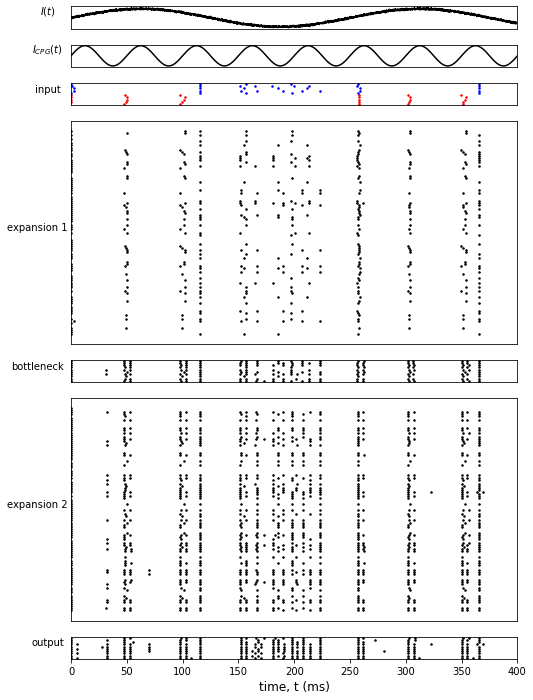

In [17]:
duration = 400

start_scope()
duration = duration*ms
mu1 = -40*mV # mean of voltage threshold distribution (input layer group 1)
mu2 = -60*mV # mean of voltage threshold distribution (input layer group 2)
sigma = 6*mV # standard deviation of voltage threshold distribution (input layer)
dt = defaultclock.dt
#print('dt/ms ='+str(dt/ms))
N = int(duration/dt)
taut = 5*ms
#s = np.random.normal(0, 1, N)
#stimulus = TimedArray(s, dt=dt)
Vr = -70*mV
Vt0 = -50*mV
tau = 10*ms
Vdrive = 0.6*mV
delta_Vt = 5*mV
delta_V  = 10*mV
CPGfreq = 20*Hz
CPGamp = 0.5*mV
tVec = np.arange(0,duration/ms,dt/ms)
cpg = CPGamp*sin(2*pi*CPGfreq*tVec/(1000*Hz))
CPG = TimedArray(cpg, dt=dt)

# make a sine wave corrupted by small amplitude white noise
#tVec = np.arange(0,duration,dt/ms)
noise = np.random.normal(0,0.05,len(tVec))
f = 4*Hz # frequency of I(t) in (Hz) (4 or 5 Hz)
det = np.sin(2*np.pi*tVec*f/(1000*Hz))
signal = (det + noise)
In = TimedArray(signal*Vdrive,dt=dt)
#plt.plot(tVec, signal)

eqsI1 = '''
dV/dt = (-V + Vt01 + In(t) + CPG(t))/tau : volt
dVt/dt = (Vt01 - Vt)/taut : volt
dVt01/dt = 0*mV/tau : volt
'''

eqsI2 = '''
dV/dt = (-V + Vt02 - In(t) + CPG(t))/tau : volt
dVt/dt = (Vt02 - Vt)/taut : volt
dVt02/dt = 0*mV/tau : volt
'''

# these equations are for the rest of the neurons
eqs = '''
dV/dt = (Vt0 - V)/tau : volt
dVt/dt = (Vt0 - Vt)/taut : volt
'''

reset = '''
V = Vr
Vt += delta_Vt
'''

# input group 1
I1 = NeuronGroup(5, eqsI1, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler')
I1.V = 'rand()*(Vt-Vr) + Vr'
I1.Vt= Vt0
I1.Vt01 = 'randn()*sigma + mu1'

# input group 2
I2 = NeuronGroup(5, eqsI2, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler')
I2.V = 'rand()*(Vt-Vr) + Vr'
I2.Vt= Vt0
I2.Vt02 = 'randn()*sigma + mu2'

# first expansion
E1 = NeuronGroup(100, eqs, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler') # 'I' for "input"
E1.V = 'rand()*(Vt-Vr)+Vr' # random initial states
E1.Vt = Vt0

# bottleneck
B = NeuronGroup(10, eqs, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler')
B.V = 'rand()*(Vt-Vr) + Vr'
B.Vt= Vt0

# second expansion
E2 = NeuronGroup(100, eqs, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler') # 'I' for "input"
E2.V = 'rand()*(Vt-Vr)+Vr' # random initial states
E2.Vt = Vt0

# output neurons (10 moth muscles)
O = NeuronGroup(10, eqs, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler')
O.V = 'rand()*(Vt-Vr) + Vr'
O.Vt= Vt0

# specify synapses from input layer 1 to first expansion layer
I1_E1 = Synapses(I1, E1, on_pre='V_post += rand()*delta_V')
I1_E1.connect(p=0.1)

# specify synapses from input layer 2 to first expansion layer
I2_E1 = Synapses(I2, E1, on_pre='V_post += rand()*delta_V')
I2_E1.connect(p=0.1)

# specify synapses from first expansion layer to bottleneck
E1_B = Synapses(E1, B, on_pre='V_post += delta_V')
E1_B.connect(p=0.1)

# specify synapses from bottleneck to second expansion layer
B_E2 = Synapses(B, E2, on_pre='V_post += delta_V')
B_E2.connect(p=0.1)

# specify synapses from second expansion layer to final output layer
E2_O = Synapses(E2, O, on_pre='V_post += delta_V')
E2_O.connect(p=0.1)

# mon = StateMonitor(I1, ['V'], record=True)
I1mon = SpikeMonitor(I1)
I2mon = SpikeMonitor(I2)
E1mon = SpikeMonitor(E1)
Bmon  = SpikeMonitor(B)
E2mon = SpikeMonitor(E2)
Omon = SpikeMonitor(O)

# net = Network(GI1,GI2,GO,syn1,syn2,mon,I1mon,I2mon,Omon)

run(duration)

fig, axes = plt.subplots(7,1,figsize = (8,12),gridspec_kw = {'height_ratios':[1,1,1,10,1,10,1]})

axes[0].plot(mon.t[:]/ms, In(mon.t[:])/mV, color='black')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlim([0,duration/ms])
axes[0].set_ylabel(r'$I(t)$',rotation=0,labelpad=20)

axes[1].plot(mon.t[:]/ms, CPG(mon.t[:])/mV, color='black')
axes[1].set_xlim([0,duration/ms])
axes[1].set_ylabel(r'$I_{CPG}(t)$',rotation=0,labelpad=20)
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].plot(I1mon.t[:]/ms, I1mon.i, color='red', marker='.', linestyle='', markersize=3)
axes[2].set_xlim([0,duration/ms])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_ylabel('input',rotation=0,labelpad=20)
axes[2].plot(I2mon.t[:]/ms, I2mon.i + 5, color='blue', marker='.', linestyle='', markersize=3)

axes[3].plot(E1mon.t[:]/ms, E1mon.i, color='black', marker='.', linestyle='', markersize=3)
axes[3].set_xlim([0,duration/ms])
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_ylabel(r'expansion 1',rotation=0,labelpad=30)

axes[4].set_ylabel('bottleneck',rotation=0,labelpad=30)
axes[4].set_xlim([0,duration/ms])
axes[4].set_yticks([])
axes[4].set_xticks([])
# axes[4].set_xlabel('time, t (ms)', fontsize=12)
axes[4].plot(Bmon.t[:]/ms, Bmon.i, color='black', marker='.', linestyle='', markersize=3)

axes[5].plot(E2mon.t[:]/ms, E2mon.i, color='black', marker='.', linestyle='', markersize=3)
axes[5].set_xlim([0,duration/ms])
axes[5].set_xticks([])
axes[5].set_yticks([])
axes[5].set_ylabel(r'expansion 2',rotation=0,labelpad=30)

axes[6].set_ylabel('output',rotation=0,labelpad=20)
axes[6].set_xlim([0,duration/ms])
axes[6].set_yticks([])
axes[6].set_xlabel('time, t (ms)', fontsize=12)
axes[6].plot(Omon.t[:]/ms, Omon.i, color='black', marker='.', linestyle='', markersize=3)

# plt.savefig('sineRaster_2pop.png',bbox_inches='tight',dpi=200)
# plt.show()
plt.savefig('bigNet.png',bbox_inches='tight',dpi=200)
st = np.sort(Omon.t/ms)
plt.draw()
